In [1]:
import json
import matplotlib.pylab as plt
import os
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

In [2]:
def calculate_f1(y_gold, y_model):
    """
    Computes the F1 of the model predictions using the
    gold labels. Each of y_gold and y_model are lists with
    labels 1 or -1. The function should return the F1
    score as a number between 0 and 1.
    """
    i = 0
    TP = 0
    TN = 0
    FP = 0
    for gold in y_gold:
        if gold == 1 and y_model[i] == 1:
            TP += 1
        if gold == 1 and y_model[i] != 1:
            TN += 1
        if gold != 1 and y_model[i] == 1:
            FP += 1
        i += 1
    precision = TP / (TP + FP + 1e-5)
    recall = TP / (TP + TN + 1e-5)
    f1 = 2 * precision * recall / (precision + recall + 1e-5)
    
    return f1

In [3]:
class Classifier(object):
    """
    The Classifier class is the base class for all of the Perceptron-based
    algorithms. Your class should override the "process_example" and
    "predict_single" functions. Further, the averaged models should
    override the "finalize" method, where the final parameter values
    should be calculated. You should not need to edit this class any further.
    """
    def train(self, X, y):
        iterations = 10
        for iteration in range(iterations):
            for x_i, y_i in zip(X, y):
                self.process_example(x_i, y_i)
            #print(iteration)
        self.finalize()

    def process_example(self, x, y):
        """
        Makes a predicting using the current parameter values for
        the features x and potentially updates the parameters based
        on the gradient. "x" is a dictionary which maps from the feature
        name to the feature value and y is either 1 or -1.
        """
        raise NotImplementedError

    def finalize(self):
        """Calculates the final parameter values for the averaged models."""
        pass

    def predict(self, X):
        """
        Predicts labels for all of the input examples. You should not need
        to override this method.
        """
        y = []
        for x in X:
            y.append(self.predict_single(x))
        return y

    def predict_single(self, x):
        """
        Predicts a label, 1 or -1, for the input example. "x" is a dictionary
        which maps from the feature name to the feature value.
        """
        raise NotImplementedError

In [4]:
class Perceptron(Classifier):
    def __init__(self, features):
        """
        Initializes the parameters for the Perceptron model. "features"
        is a list of all of the features of the model where each is
        represented by a string.
        """
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = 1   # learning rate
        self.w = {feature: 0.0 for feature in features}   # dictionary of feature: 0.0
        self.theta = 0

    def process_example(self, x, y): # if y_predict not equal with y_true, update the w and theta
        y_pred = self.predict_single(x)
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  # perceptron
        #print(score)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value
            #print("1")
            self.theta += self.eta * y

    def predict_single(self, x):  # get the y_predict
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  # perceptron
        if score <= 0:
            return -1
        return 1

For the rest of the Perceptron-based algorithms, you will have to implement the corresponding class like we have done for "Perceptron".
Use the "Perceptron" class as a guide for how to implement the functions.

In [6]:
class AveragedPerceptron(Classifier):
    def __init__(self, features):
        self.eta = 1
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        # You will need to add data members here
        self.features = features
        self.M = 0
        self.w_sum = {feature: 0.0 for feature in features}
        self.theta_sum = 0
        self.m = 0
        
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y == y_pred:
            self.m += 1
        else:
            for feature, value in x.items():
                self.w[feature] += self.eta * value * y  
                self.w_sum[feature] += self.eta * value * y *self.M
            self.theta += self.eta * y
            self.theta_sum += self.eta * y * self.M
            self.M += self.m
            self.m = 1
        

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  # averageperceptron
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        for feature, value in self.w_sum.items():           
            self.w[feature] -= value / self.M
        self.theta -= self.theta_sum  / self.M
        self.w_sum = {feature: 0.0 for feature in self.features}
        self.theta_sum = 0
        self.M = 0
        self.m = 0
        

In [7]:
class Winnow(Classifier):
    def __init__(self, alpha, features):
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
   
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] *= self.alpha ** (y * value)

        

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  #winnow
        if score <= 0:
            return -1
        return 1
        

In [8]:
class AveragedWinnow(Classifier):
    def __init__(self, alpha, features):
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
        # You will need to add data members here
        self.features = features
        self.M = 0
        self.w_sum = {feature: 0.0 for feature in features}
        self.m = 0
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)        
        if y == y_pred:            
            self.m += 1        
        else:
            for feature, value in self.w.items():
                self.w_sum[feature] += self.m * value
            for feature, value in x.items():
                self.w[feature] *= self.alpha ** (y * value)
            self.M += self.m
            self.m = 1
            
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  #average winnow
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        if self.m >= 1:
            for feature, value in self.w.items():
                self.w_sum[feature] += self.m * value
            self.M += self.m
        for feature, value in self.w_sum.items():
            self.w[feature] = value / self.M
        

In [9]:
class AdaGrad(Classifier):
    def __init__(self, eta, features):
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}  # 1e-5 prevents divide by 0 problems
        self.H = 1e-7
     
        
    def process_example(self, x, y):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta 
        if y * score <= 1:                  
             # calculate G and H
            for feature, value in x.items():
                self.G[feature] += (y * value)**2
            self.H += (y)**2            
            # update the w and theta
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value / (self.G[feature] ** (1/2))
             
            self.theta += self.eta * y / (self.H ** (1/2))
         
    

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  # adagrad
        if score <= 0:
            return -1
        return 1

In [10]:
class AveragedAdaGrad(Classifier):
    def __init__(self, eta, features):
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}
        self.H = 1e-5
        # You will need to add data members here
        self.M = 0
        self.theta_sum = 0
        self.w_sum = {feature:0.0 for feature in features}
        self.m = 0
        
    def process_example(self, x, y):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta 
        if y * score > 1:
            self.m += 1
        else:            
            # calculate G and H
            for feature, value in x.items():
                self.G[feature] += (- y * value)**2
            self.H += (-y)**2            
            # add sum
            for feature, value in self.w.items():
                self.w_sum[feature] += self.m * value
            # update the w and theta
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value / (self.G[feature] ** (1/2))
            self.theta_sum += self.m * self.theta
            self.theta += self.eta * y / (self.H ** (1/2))              
            # reset m = 1
            self.M += self.m
            self.m = 1
        
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta  # averageadagrad
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        if self.m >= 1:
            for feature, value in self.w.items():
                self.w_sum[feature] += self.m * value
            self.M += self.m
        for feature, value in self.w_sum.items():
            self.w[feature] = self.w_sum[feature] * (1 / self.M)
        self.theta = self.theta_sum / self.M

In [11]:
def plot_learning_curves(perceptron_accs,
                         winnow_accs,
                         adagrad_accs,
                         avg_perceptron_accs,
                         avg_winnow_accs,
                         avg_adagrad_accs,
                         svm_accs):
    """
    This function will plot the learning curve for the 7 different models.
    Pass the accuracies as lists of length 11 where each item corresponds
    to a point on the learning curve.
    """
    assert len(perceptron_accs) == 11
    assert len(winnow_accs) == 11
    assert len(adagrad_accs) == 11
    assert len(avg_perceptron_accs) == 11
    assert len(avg_winnow_accs) == 11
    assert len(avg_adagrad_accs) == 11
    assert len(svm_accs) == 11

    x = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 50000]
    plt.figure()
    f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    ax.plot(x, perceptron_accs, label='perceptron')
    ax2.plot(x, perceptron_accs, label='perceptron')
    ax.plot(x, winnow_accs, label='winnow')
    ax2.plot(x, winnow_accs, label='winnow')
    ax.plot(x, adagrad_accs, label='adagrad')
    ax2.plot(x, adagrad_accs, label='adagrad')
    ax.plot(x, avg_perceptron_accs, label='avg-perceptron')
    ax2.plot(x, avg_perceptron_accs, label='avg-perceptron')
    ax.plot(x, avg_winnow_accs, label='avg-winnow')
    ax2.plot(x, avg_winnow_accs, label='avg-winnow')
    ax.plot(x, avg_adagrad_accs, label='avg-adagrad')
    ax2.plot(x, avg_adagrad_accs, label='avg-adagrad')
    ax.plot(x, svm_accs, label='svm')
    ax2.plot(x, svm_accs, label='svm')
    ax.set_xlim(0, 5500)
    ax2.set_xlim(49500, 50000)
    ax2.set_xticks([50000])
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax2.legend()

In [12]:
def load_synthetic_data(directory_path):
    """
    Loads a synthetic dataset from the dataset root (e.g. "synthetic/sparse").
    You should not need to edit this method.
    """
    def load_jsonl(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        return data

    def load_txt(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(int(line.strip()))
        return data

    def convert_to_sparse(X):
        sparse = []
        for x in X:
            data = {}
            for i, value in enumerate(x):
                if value != 0:
                    data[str(i)] = value
            sparse.append(data)
        return sparse

    X_train = load_jsonl(directory_path + '/train.X')
    X_dev = load_jsonl(directory_path + '/dev.X')
    X_test = load_jsonl(directory_path + '/test.X')

    num_features = len(X_train[0])
    features = [str(i) for i in range(num_features)]

    X_train = convert_to_sparse(X_train)
    X_dev = convert_to_sparse(X_dev)
    X_test = convert_to_sparse(X_test)

    y_train = load_txt(directory_path + '/train.y')
    y_dev = load_txt(directory_path + '/dev.y')
    y_test = load_txt(directory_path +  '/test.y')

    return X_train, y_train, X_dev, y_dev, X_test, y_test, features

In [13]:
def run_synthetic_experiment(data_path):
    """
    Runs the synthetic experiment on either the sparse or dense data
    depending on the data path (e.g. "data/sparse" or "data/dense").
    
    We have provided how to train the Perceptron on the training and
    test on the testing data (the last part of the experiment). You need
    to implement the hyperparameter sweep, the learning curves, and
    predicting on the test dataset for the other models.
    """
    X_train, y_train, X_dev, y_dev, X_test, y_test, features \
        = load_synthetic_data(data_path)
    
    # TODO: Hyperparameter sweeps
    eta_lst = [1.5, 0.25, 0.03, 0.005, 0.001]
    alpha_lst = [1.1, 1.01, 1.005, 1.0005, 1.0001]
    
    # Standard Winnow 
    # train classifier and get the acc for each alpha
    winnow_acc_lst = []
    for alpha in alpha_lst:
        classifier = Winnow(alpha, features)
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        winnow_acc_lst.append(acc)
        print("Winnow (alpha = " + str(alpha) + "), acc = " + str(acc))
    print(winnow_acc_lst)
    # get best alpha
    large_acc = winnow_acc_lst[0]
    for acc in winnow_acc_lst:
        if acc > large_acc:
            large_acc = acc
    alpha_Winnow = alpha_lst[winnow_acc_lst.index(large_acc)]
    print("The best hyperparameter of Winnow is alpha = " + str(alpha_Winnow))
    
    # Averaged Winnow 
    # train classifier and get the acc for each alpha
    Average_winnow_acc_lst = []
    for alpha in alpha_lst:
        classifier = AveragedWinnow(alpha, features)
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        Average_winnow_acc_lst.append(acc)
        print("AverageWinnow (alpha = " + str(alpha) + "), acc = " + str(acc))
    print(Average_winnow_acc_lst)
    # get best alpha
    large_acc = Average_winnow_acc_lst[0]
    for acc in Average_winnow_acc_lst:
        if acc > large_acc:
            large_acc = acc
    alpha_AverageWinnow = alpha_lst[Average_winnow_acc_lst.index(large_acc)]
    print("The best hyperparameter of AverageWinnow is alpha = " + str(alpha_AverageWinnow))
    
    # Perceptron with AdaGrad 
    # train classifier and get the acc for each eta
    AdaGrad_acc_lst = []
    for eta in eta_lst:
        classifier = AdaGrad(eta, features)
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        AdaGrad_acc_lst.append(acc)
        print("AdaGrad (eta = " + str(eta) + "), acc = " + str(acc))
    print(AdaGrad_acc_lst)
    # get best eta
    large_acc = AdaGrad_acc_lst[0]
    for acc in AdaGrad_acc_lst:
        if acc > large_acc:
            large_acc = acc
    eta_AdaGrad = eta_lst[AdaGrad_acc_lst.index(large_acc)]
    print("The best hyperparameter of AdaGrad is eta = " + str(eta_AdaGrad))   
    
    # Perceptron with AverageAdaGrad 
    # train classifier and get the acc for each eta
    Average_AdaGrad_acc_lst = []
    for eta in eta_lst:
        classifier = AveragedAdaGrad(eta, features)
        classifier.train(X_train, y_train)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        Average_AdaGrad_acc_lst.append(acc)
        print("AverageAdaGrad (eta = " + str(eta) + "), acc = " + str(acc))
    print(Average_AdaGrad_acc_lst)
    # get best eta
    large_acc = Average_AdaGrad_acc_lst[0]
    for acc in Average_AdaGrad_acc_lst:
        if acc > large_acc:
            large_acc = acc
    eta_AverageAdaGrad = eta_lst[Average_AdaGrad_acc_lst.index(large_acc)]
    print("The best hyperparameter of AverageAdaGrad is eta = " + str(eta_AverageAdaGrad))   
    
            
    # TODO: Placeholder data for the learning curves. You should write
    # the logic to downsample the dataset to the number of desired training
    # instances (e.g. 500, 1000), then train all of the models on the
    # sampled dataset. Compute the accuracy and add the accuraices to
    # the corresponding list.
    perceptron_accs = [0.1] * 11
    winnow_accs = [0.2] * 11
    adagrad_accs = [0.3] * 11
    avg_perceptron_accs = [0.4] * 11
    avg_winnow_accs = [0.5] * 11
    avg_adagrad_accs = [0.6] * 11
    svm_accs = [0.7] * 11
    
    example_num = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 50000]
    
    # Perceptron
    classifier = Perceptron(features)
    i = 0
    for num in example_num:
        X_train_per = X_train[:num]
        y_train_per = y_train[:num]
        classifier.train(X_train_per, y_train_per)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        perceptron_accs[i] = acc   
        i += 1
    
    #Winnow
    classifier = Winnow(alpha_Winnow, features)
    i = 0
    for num in example_num:
        X_train_win = X_train[:num]
        y_train_win = y_train[:num]
        classifier.train(X_train_win, y_train_win)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        winnow_accs[i] = acc
        i += 1
        
    #AdaGrad
    classifier = AdaGrad(eta_AdaGrad, features)
    i = 0
    for num in example_num:
        X_train_ada = X_train[:num]
        y_train_ada = y_train[:num]
        classifier.train(X_train_ada, y_train_ada)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        adagrad_accs[i] = acc
        i += 1
    
    # AveragePerceptron
    classifier = AveragedPerceptron(features)
    i = 0
    for num in example_num:
        X_train_avdper = X_train[:num]
        y_train_avdper = y_train[:num]
        classifier.train(X_train_avdper, y_train_avdper)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        avg_perceptron_accs[i] = acc
        i += 1
    
    # AverageWinnow
    classifier = AveragedWinnow(alpha_AverageWinnow, features)
    i = 0
    for num in example_num:
        X_train_avdwin = X_train[:num]
        y_train_avdwin = y_train[:num]
        classifier.train(X_train_avdwin, y_train_avdwin)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        avg_winnow_accs[i] = acc
        i += 1;

    # AverageAdaGrad
    classifier = AveragedAdaGrad(eta_AverageAdaGrad, features)
    i = 0
    for num in example_num:
        X_train_avdada = X_train[:num]
        y_train_avdada = y_train[:num]
        classifier.train(X_train_avdada, y_train_avdada)
        y_pred = classifier.predict(X_dev)
        acc = accuracy_score(y_dev, y_pred)
        avg_adagrad_accs[i] = acc
        i += 1
   
    
    # SVM
    from sklearn.svm import LinearSVC
    vectorizer = DictVectorizer()
    classifier = LinearSVC(loss = 'hinge')
    index = 0
    for num in example_num:
        X_train_SVM = X_train[:num]
        X_train_dict = vectorizer.fit_transform(X_train_SVM)
        y_train_SVM = y_train[:num]
        
        classifier = classifier.fit(X_train_dict, y_train_SVM)
        X_dev_dict = vectorizer.fit_transform(X_dev)
        y_pred = classifier.predict(X_dev_dict)
        acc = accuracy_score(y_dev, y_pred)
        svm_accs[index] = acc
        index += 1

    
    plot_learning_curves(perceptron_accs, winnow_accs, adagrad_accs, avg_perceptron_accs, avg_winnow_accs, avg_adagrad_accs, svm_accs)
    
    # TODO: Train all 7 models on the training data and test on the test data
    
    # Perceptron
    classifier = Perceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Perceptron', acc)
    
    # AveragePerceptron
    classifier = AveragedPerceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('AveragePerceptron', acc)
    
    # Winnow
    classifier = Winnow(alpha_Winnow, features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('Winnow', acc)
    
    # AverageWinnow
    classifier = AveragedWinnow(alpha_AverageWinnow, features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('AverageWinnow', acc)
    
    # AdaGrad
    classifier = AdaGrad(eta_AdaGrad, features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('AdaGrad', acc)
    
    # AverageAdaGrad
    classifier = AveragedAdaGrad(eta_AverageAdaGrad, features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('AverageAdaGrad', acc)
    
    # SVM
    from sklearn.svm import LinearSVC
    vectorizer = DictVectorizer()
    classifier = LinearSVC(loss = 'hinge')
    X_train_dict = vectorizer.fit_transform(X_train)
    classifier = classifier.fit(X_train_dict, y_train)
    X_test_dict = vectorizer.fit_transform(X_test)
    y_pred = classifier.predict(X_test_dict)
    acc = accuracy_score(y_test, y_pred)
    print('SVM', acc)
    
    
    
    

In [14]:
def load_ner_data(path):
    """
    Loads the NER data from a path (e.g. "ner/conll/train"). You should
    not need to edit this method.
    """
    # List of tuples for each sentence
    data = []
    for filename in os.listdir(path):
        with open(path + '/' + filename, 'r') as file:
            sentence = []
            for line in file:
                if line == '\n':
                    data.append(sentence)
                    sentence = []
                else:
                    sentence.append(tuple(line.split()))
    return data

In [15]:
def extract_ner_features_train(train):
    """
    Extracts feature dictionaries and labels from the data in "train"
    Additionally creates a list of all of the features which were created.
    We have implemented the w-1 and w+1 features for you to show you how
    to create them.
    
    TODO: You should add your additional featurization code here.
    """
    y = []
    X = []
    features = set()
    for sentence in train:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            feat3 = 'w-2=' + str(padded[i - 2][0])
            feat4 = 'w+2=' + str(padded[i + 2][0])
            feat5 = 'w-3=' + str(padded[i - 3][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = feat1 + '&' + feat3
            feat8 = feat2 + '&' + feat4
            feat9 = feat1 + '&' + feat2
            
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            features.update(feats)
            feats = {feature: 1 for feature in feats}
            X.append(feats)
         
    return features, X, y

In [16]:
def extract_features_dev_or_test(data, features):
    """
    Extracts feature dictionaries and labels from "data". The only
    features which should be computed are those in "features". You
    should add your additional featurization code here.
    
    TODO: You should add your additional featurization code here.
    """
    y = []
    X = []
    for sentence in data:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            
            # add my code and edit existed codes
            feat3 = 'w-2=' + str(padded[i - 2][0])
            feat4 = 'w+2=' + str(padded[i + 2][0])
            feat5 = 'w-3=' + str(padded[i - 3][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = feat1 + '&' + feat3
            feat8 = feat2 + '&' + feat4
            feat9 = feat1 + '&' + feat2
            
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            feats = {feature: 1 for feature in feats if feature in features}
            X.append(feats)
    return X, y

In [17]:
def run_ner_experiment(data_path):
    """
    Runs the NER experiment using the path to the ner data
    (e.g. "ner" from the released resources). We have implemented
    the standard Perceptron below. You should do the same for
    the averaged version and the SVM.
    
    The SVM requires transforming the features into a different
    format. See the end of this function for how to do that.
    """
    train = load_ner_data(data_path + '/conll/train')
    conll_test = load_ner_data(data_path + '/conll/test')
    enron_test = load_ner_data(data_path + '/enron/test')

    features, X_train, y_train = extract_ner_features_train(train)
    X_conll_test, y_conll_test = extract_features_dev_or_test(conll_test, features)
    X_enron_test, y_enron_test = extract_features_dev_or_test(enron_test, features)
                 
    # You should do this for the Averaged Perceptron and SVM
    classifier = Perceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_conll_test)
    conll_f1 = calculate_f1(y_conll_test, y_pred)
    y_pred = classifier.predict(X_enron_test)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('Perceptron')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)
    
    # Averaged Perceptron
    classifier = AveragedPerceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_conll_test)
    conll_f1 = calculate_f1(y_conll_test, y_pred)
    y_pred = classifier.predict(X_enron_test)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('Averaged Perceptron')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)
    
    # This is how you convert from the way we represent features in the
    # Perceptron code to how you need to represent features for the SVM.
    # You can then train with (X_train_dict, y_train) and test with
    # (X_conll_test_dict, y_conll_test) and (X_enron_test_dict, y_enron_test)
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train)
    X_conll_test_dict = vectorizer.transform(X_conll_test)
    X_enron_test_dict = vectorizer.transform(X_enron_test)
    
    # SVM
    from sklearn.svm import LinearSVC
    classifier = LinearSVC(loss = 'hinge')
    classifier.fit(X_train_dict, y_train)
    y_pred = classifier.predict(X_conll_test_dict)
    conll_f1 = calculate_f1(y_conll_test, y_pred)
    y_pred = classifier.predict(X_enron_test_dict)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('SVM')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)

Winnow (alpha = 1.1), acc = 0.9196
Winnow (alpha = 1.01), acc = 0.929
Winnow (alpha = 1.005), acc = 0.9335
Winnow (alpha = 1.0005), acc = 0.9117
Winnow (alpha = 1.0001), acc = 0.5863
[0.9196, 0.929, 0.9335, 0.9117, 0.5863]
The best hyperparameter of Winnow is alpha = 1.005
AverageWinnow (alpha = 1.1), acc = 0.9433
AverageWinnow (alpha = 1.01), acc = 0.9361
AverageWinnow (alpha = 1.005), acc = 0.9239
AverageWinnow (alpha = 1.0005), acc = 0.7241
AverageWinnow (alpha = 1.0001), acc = 0.5431
[0.9433, 0.9361, 0.9239, 0.7241, 0.5431]
The best hyperparameter of AverageWinnow is alpha = 1.1
AdaGrad (eta = 1.5), acc = 0.9433
AdaGrad (eta = 0.25), acc = 0.9046
AdaGrad (eta = 0.03), acc = 0.7374
AdaGrad (eta = 0.005), acc = 0.5068
AdaGrad (eta = 0.001), acc = 0.5015
[0.9433, 0.9046, 0.7374, 0.5068, 0.5015]
The best hyperparameter of AdaGrad is eta = 1.5
AverageAdaGrad (eta = 1.5), acc = 0.9433
AverageAdaGrad (eta = 0.25), acc = 0.8413
AverageAdaGrad (eta = 0.03), acc = 0.725
AverageAdaGrad (eta =

/Users/ruizi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Perceptron 0.8277
AveragePerceptron 0.9433
Winnow 0.9337
AverageWinnow 0.9433
AdaGrad 0.9433
AverageAdaGrad 0.9433
SVM 0.9433


<Figure size 432x288 with 0 Axes>

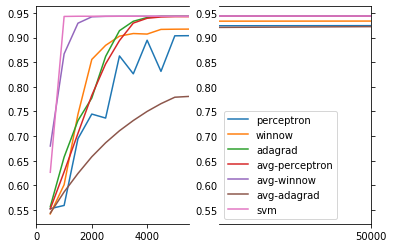

In [18]:
# Run the synthetic experiment on the sparse dataset. "synthetic/sparse"
# is the path to where the data is located.
run_synthetic_experiment('synthetic/sparse')

Winnow (alpha = 1.1), acc = 0.9038
Winnow (alpha = 1.01), acc = 0.9368
Winnow (alpha = 1.005), acc = 0.9341
Winnow (alpha = 1.0005), acc = 0.9351
Winnow (alpha = 1.0001), acc = 0.8405
[0.9038, 0.9368, 0.9341, 0.9351, 0.8405]
The best hyperparameter of Winnow is alpha = 1.01
AverageWinnow (alpha = 1.1), acc = 0.9401
AverageWinnow (alpha = 1.01), acc = 0.9401
AverageWinnow (alpha = 1.005), acc = 0.938
AverageWinnow (alpha = 1.0005), acc = 0.8679
AverageWinnow (alpha = 1.0001), acc = 0.7054
[0.9401, 0.9401, 0.938, 0.8679, 0.7054]
The best hyperparameter of AverageWinnow is alpha = 1.1
AdaGrad (eta = 1.5), acc = 0.9401
AdaGrad (eta = 0.25), acc = 0.9401
AdaGrad (eta = 0.03), acc = 0.6134
AdaGrad (eta = 0.005), acc = 0.4961
AdaGrad (eta = 0.001), acc = 0.4961
[0.9401, 0.9401, 0.6134, 0.4961, 0.4961]
The best hyperparameter of AdaGrad is eta = 1.5
AverageAdaGrad (eta = 1.5), acc = 0.9401
AverageAdaGrad (eta = 0.25), acc = 0.887
AverageAdaGrad (eta = 0.03), acc = 0.6014
AverageAdaGrad (eta = 

<Figure size 432x288 with 0 Axes>

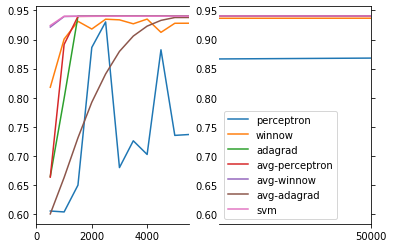

In [19]:
# Run the synthetic experiment on the sparse dataset. "synthetic/dense"
# is the path to where the data is located.
run_synthetic_experiment('synthetic/dense')

In [20]:
# Run the NER experiment. "ner" is the path to where the data is located.
run_ner_experiment('/Users/ruizi/Desktop/hw2-materials/ner')

Perceptron
  CoNLL 0.793147679095427
  Enron 0.17413747794504425
Averaged Perceptron
  CoNLL 0.7988892754520269
  Enron 0.2237574356152151
SVM
  CoNLL 0.8278187001604884
  Enron 0.24067676519511835
